# HOTELS - Analyse Verbatim-clients déposés sur Trip Advisor 

(1) Préparation du répertoire et des principaux packages

In [1]:
import os
os.chdir("C:/Disney")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
import gensim
print(gensim.__version__)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chrys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


4.1.2


# I. Analyses préparatoires avec les avis sur l'hôtel Marvel

**Objectif : test& learn** -> réaliser les premières analyses sur un petit fichier comprenant uniquement des avis récents avant de généraliser sur les autres hôtels.

**(1) Premières visualisations du fichier**
préalablement traduit et nettoyé avec les dictionnaires stop of words de la librairie ntlk (cf.notre fonction de nettoyage)

In [3]:
marvel=pd.read_csv("hotel_marvel_clean.csv", sep=",")
marvel.info( ) #439 avis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   titre_commentaire  440 non-null    object
 1   commentaire        440 non-null    object
 2   Date               440 non-null    object
 3   Ville              440 non-null    object
 4   Pays               440 non-null    object
 5   Note               440 non-null    int64 
 6   Photo              440 non-null    object
 7   langue             440 non-null    object
dtypes: int64(1), object(7)
memory usage: 27.6+ KB


In [4]:
#visualisation des premières lignes
marvel.head()

,titre_commentaire,commentaire,Date,Ville,Pays,Note,Photo,langue
0,"['super', 'hôtel', 'thème', 'marvel', 'disneyl...","['super', 'hôtel', 'thème', 'marvel', 'décors'...",déc 2022,Valenciennes,France,5,yes,fr
1,"['attendais', 'mieux']","['peu', 'déçue', 'hôtel', 'très', 'belle', 'ch...",nov 2022,None,None,4,no,fr
2,['ravie'],"['avon', 'vraiment', 'apprécié', 'nuit', 'cet'...",nov 2022,None,None,4,no,fr
3,"['avis', 'mitigé']","['bel', 'hôtel', 'neuf', 'magique', 'yeux', 'e...",nov 2022,Calvi,France,3,no,fr
4,['fabuleux'],"['superbe', 'accueil', 'castmembers', 'récepti...",nov 2022,Toulouse,France,5,yes,fr


In [5]:
#Le fichier comprend des avis datés entre juin 2021 et décembre 2022
marvel['Date'].tail(1)

439    juin 2022
Name: Date, dtype: object

In [6]:
#Comptage des mots pour se donner une première idée des thèmes et d'un nettoyage complémentaire éventuel à opérer
import re
import collections

In [7]:
# titre 
t=marvel['titre_commentaire']
t.head()

0    ['super', 'hôtel', 'thème', 'marvel', 'disneyl...
1                               ['attendais', 'mieux']
2                                            ['ravie']
3                                   ['avis', 'mitigé']
4                                         ['fabuleux']
Name: titre_commentaire, dtype: object

In [263]:
# commentaire
tx=marvel['commentaire']
tx.head(3)

0    ['super', 'hôtel', 'thème', 'marvel', 'décors'...
1    ['peu', 'déçue', 'hôtel', 'très', 'belle', 'ch...
2    ['avon', 'vraiment', 'apprécié', 'nuit', 'cet'...
Name: commentaire, dtype: object

# II. Répartition des profils-clients : le français en langue d'analyse fait sens.

(1). Langue du commentaire : plus de la moitié de francophones, suivis assez loin par les anglophones (près de 2 fois moins). 

<AxesSubplot:xlabel="Langue de l'avis", ylabel='Nombre de répondants'>

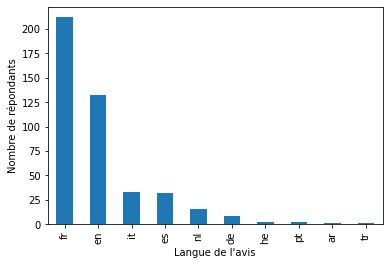

In [227]:
comptage=marvel['langue'].value_counts()
comptage.plot(kind='bar',stacked=True,ylabel="Nombre de répondants",xlabel="Langue de l'avis")

(2). Les 2 graphiques suivants indiquent qu'il n'y a pas de différences significatives en matière de ventilation des notes selon que l'avis provient d'un francophone ou non (1er graphique).
Les répartitions des notes principalement données sont '4' et '5' chez les principales clientèles, elles sont même identiques chez les francophones et les Italiens (2è graphique). 

<AxesSubplot:ylabel='langue'>

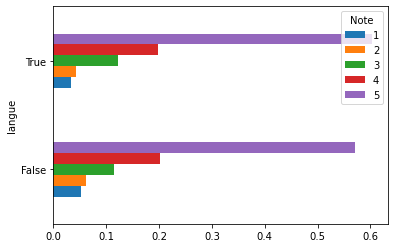

In [189]:
T=pd.crosstab(marvel['langue']=='fr',marvel['Note'], normalize='index')
T.plot.barh()

Note    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

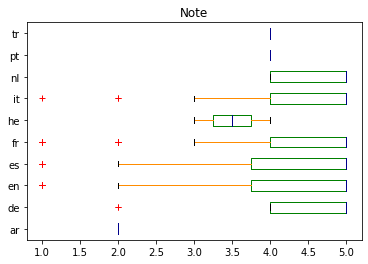

In [194]:
#Boîte de Turkey
color=dict(boxes='green',whiskers='DarkOrange',medians='DarkBlue',caps='Black')
marvel.plot.box(column='Note',by='langue',color=color,sym='r+',vert=False)

(3). Ventilation des notes

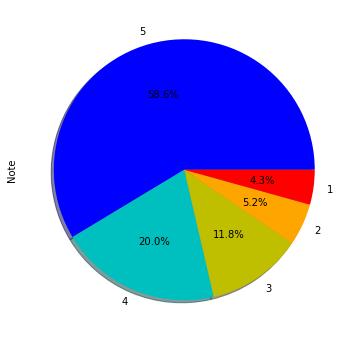

In [246]:
plt.figure(figsize=(6, 6))
cols = ['b','c','y','orange','r']
marvel['Note'].value_counts().plot.pie(autopct='%1.1f%%', shadow= True,colors=cols)
plt.show()

# III.Word2Vec avec Gensim

**(1) Cas d'usage sur les commentaires : visualisation de la procédure de nettoyage et de tokenisation des verbatim**.

Nous détaillons ici la préparation des données pour la vectorisation, embarquée sous forme automatisée dans notre fonction de nettoyage : retrait des ponctuations, tokenisation, lemmatisation.
Les fichiers en soi sont utilisables directement pour procéder à la vectorisation. 

In [117]:
#récupération sous forme de liste 
corpus=tx.tolist()
print(corpus[50])

['récemment', 'passé', 'deux', 'nuits', 'cet', 'hôtel', 'apprécié', 'séjour', 'fan', 'marvel', 'hôtel', 'incontournable', 'imo', 'thème', 'hôtel', 'super', 'cool', 'personnel', 'formidable', 'aussi', 'hôtel', 'peu', 'cher', 'pourquoi', 'noté', 'valeur', 'donné', 'service', 'lié', 'ménage', 'obtenir', 'ménage', 'laisser', 'café', 'supplémentaire', 'eau', 'café', 'donne', 'approvisionnement', 'minimal', 'réapprovisionné', 'pendant', 'séjour', 'cela', 'semblait', 'idiot', 'prix', 'chambre', 'pouvais', 'obtenir', 'quelques', 'dosettes', 'supplémentaires', 'café', 'petite', 'crèmes', 'sucre']


In [13]:
# (1) Passage en minuscules
corpus=[doc.lower() for doc in corpus]
print(corpus[100])

['passé', 'nuits', 'enfants', 'hôtel', 'incroyable', 'garçons', 'aiment', 'merveilles', 'seul', 'dommage', 'avon', 'raté', 'ouverture', 'campus', 'avenger', 'adoré', 'station', 'superhéros', 'hôtel', 'toutes', 'œuvres', 'art', 'merveilleuses', 'hôtel', 'proche', 'pouvions', 'faire', 'première', 'heure', 'parc', 'puis', 'revenir', 'petit', 'déjeuner', 'tout', 'personnel', 'très', 'sympathique', 'voyage', 'unique', 'souvenir', 'spéciaux', 'créés']


In [248]:
# (2) retrait des ponctuations
import string
ponctuations= list(string.punctuation)

In [15]:
corpus= ["".join([char for char in list (doc) if not (char in ponctuations)]) for doc in corpus]
print(corpus[200])

habitué disneyland hôtel somme rabattus celuici car disney village parc accessible pied arrivée hall majestueux sublimes dessins hauteur sou plafond impressionnante check peu long long heure covid bref récupérons direction parc plus recevez quand chambre prête code accès ouvrir porte soir arrivée découvrons sublime chambre beaucoup petite attention chocolats macarons bonbon cadeaux effigie hôte enfants sac gourde bref hésitez plus réserver sans hésiter surtout enfants fan héros marvel chez fille plutôt princesse fils grandit…


In [16]:
#(2)
#transformer les corpus en liste de liste (les documents)
#par tokenisation
from nltk.tokenize import word_tokenize
corpus_tk=[word_tokenize(doc) for doc in corpus]
print(corpus_tk[17])

['voyage', 'disney', 'première', 'fois', 'séjournais', 'hny', 'dîné', 'ici', 'avant', 'rénovations', 'très', 'impressionné', 'hôtel', 'rénovations', 'thématique', 'marvel', 'excellente', 'somme', 'arrivés', 'heure', 'déjeuner', 'avon', 'ravis', 'apprendre', 'chambre', 'prête', 'chambre', 'propre', 'moderne', 'spacieuse', 'personnel', 'excellent', 'partout', 'rien', 'trop', 'demander', 'problème', 'mineur', 'laissezpasser', 'magiques', 'arrivée', 'dame', 'réception', 'rapidement', 'réglé', 'problème', 'plan', 'repas', 'disney', 'avon', 'pris', 'petit', 'déjeuner', 'dîner', 'hôtel', 'tous', 'deux', 'excellents', 'beaucoup', 'choix', 'nourriture', 'chaude', 'etc', 'enfants', 'adoré', 'avantage', 'station', 'superhéros', 'équipement', 'merveilleux', 'piscine', 'également', 'plu', 'piscine', 'immense', 'peutêtre', 'peu', 'froide', 'problème', 'la…']


In [17]:
#(3)
#lemmatisation (rapprocher les mots de la même famille "est", "es"= être))
from nltk.stem import WordNetLemmatizer
lem =WordNetLemmatizer()
corpus_lm=[[lem.lemmatize(mot) for mot in doc] for doc in corpus_tk]
print(corpus_lm[8])

['fantastique', 'hôtel', 'marvel', 'new', 'york', 'près', 'parc', 'chambres', 'assez', 'propres', 'détail', 'quand', 'reviennent', 'aprèsmidi', 'super', 'soulignerais', 'boutiqueboutique', 'downtown', 'espace', 'enfants', 'peuvent', 'dessiner', 'acheté', 'désodorisant', 'hôtel', 'maison', 'sent', 'bon', 'point', 'améliorer', 'dirais', 'pourraient', 'être', 'peu', 'plus', 'agiles', 'moment', 'file', 'attente', 'entrer', 'restaurant', 'prix', 'très', 'élevé', 'tout', 'monde', 'peut', 'permettre']


**Retrait des mots vides : les stopwords du package comprennent 179 mots vides fréquents. Nous allons compléter la liste manuellement : certains mots vides comme pourtant arrivent dans le haut du classement et créent du bruit pour les mots utiles**

In [244]:
#(4) charger les stopwords (179 dans la liste initiale), compléter de qq mots vides courants pourtant non répertoriés
# qui arrivent pour certains dans le top des mots les plus fréquents dans les verbatim (ex:"pourtant","cet","dessus"),
# et ajouter ceux propres à Disney et à l'hôtel (marvel, disney)
#from nltk.corpus import stopwords
nltk.download('stopwords')
mots_vides = stopwords.words('french')+ ["marvel","disney","disneyland","hny","new","york","la…","pourtant","car","cependant","toutefois", "néanmoins", "grâce","auron","avon","cela","cet","tout","donc","le…","dès","déjà","bref","jusqu","malgré","ceux","vers","plutôt","etc","tant","entre","puis","leurs","ensuite","afin","parce","estàdire","luimême","sen","quelle","ailleurs","dessus","avoir","oui","newyork","appelle","peuvent","pourraient","littéralement","devenu"] 
print(len(mots_vides)) #207 mots vide retirés en tout

207


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chrys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [249]:
#suppresion des mots vides
corpus_sw=[[mot for mot in doc if not (mot in mots_vides)] for doc in corpus_lm]

In [250]:
#suppression des chiffres
chiffres = list("0123456789")
corpus_su=[[mot for mot in doc if not (mot in chiffres)] for doc in corpus_sw]

In [251]:
#(5) retirer les mots de moins de 3 lettres
corpus_sw=[[mot for mot in doc if len(mot) >= 3] for doc in corpus_su]

**(2) Vectorisation** 

Nous partons sur un vecteur à 2 dimensions pour réaliser les graphiques de représentation spatiale des termes.

In [23]:
#word2vec
from gensim.models import Word2Vec
modele = Word2Vec(corpus_sw,vector_size=2,window=5) #size = 2 ; 2 axes #window= 5 termes-voisins
type(modele)

gensim.models.word2vec.Word2Vec

In [24]:
#word vectors (wv) = transcription en vecteurs de la liste des termes
words= modele.wv
print(type(words))

<class 'gensim.models.keyedvectors.KeyedVectors'>


In [25]:
#dir(words)

In [276]:
#words.key_to_index

**Les dimensions** : 815 termes et matrice à 2 dimensions (comme demandé plus haut)

In [27]:
words.vectors.shape

(813, 2)

**(3) Recherche des points de friction vs des points porteurs de satisfaction**

**a-Regardons les coordonnées de quelques mots marquants parmi les plus fréquents antinomiques de prime abord comme décevant et magic ->** 
Dans quelle mesure sont-ils proches dans l'espace de représentation ? 

In [57]:
#coordonnées de magic
vec1=words['magic']
print(vec1)

[0.5221672  0.26961017]


In [29]:
#coordonnées de décevant
vec2=words['décevant']
print(vec2)

[0.35077918 0.5899751 ]


Les 2 termes **"Magic" et "Décevant"** sont assez proches dans l'espace de représentation (0.84). iso pour magique (=magic).

In [58]:
#smilarité cosinus -- formule (produit scalaire des 2 vecteurs divisé par le produit des normes)
print(np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))

0.8484447


In [54]:
#magique/magic : 2 termes similaires
words.similarity("magique","magic")

0.99492687

**Qu'en est-il de "peluches" et de "magic"/"magique"?**
les termes sont quasiment superposés (0.94)

In [31]:
#utilisation de la similarité cosinus embarquée dans le package gensim
words.similarity("peluches","magic")

0.9391123

**b- NETTOYAGE, CALME, GATEAU, SPECTACLE, EQUIPEMENTS POUR BEBE et l'EMPLACEMENT (=ASSOCIE A "PROBLEME") en points de friction**

1- les termes les plus proches de la conjonction "magic" /"magique" et "décevant"** sont "nettoyage" et "calme". Il semble exister également une zone de déception à l'égard des gâteaux.

In [62]:
#les mots les plus proches de la conjonction de "décevant" et de "magic": calme, négatif, nettoyage,revenus
print(words.most_similar(positive=["magic","décevant"],topn=2))

[('nettoyage', 0.9999993443489075), ('calme', 0.9999990463256836)]


In [89]:
#les mots les plus proches de "magique" et les plus éloignés de "décevant": intéressant de noter que "déçue", "voulions" et "gâteau"
#proches de "magique": attentes non concrétisées pour quelques clients (cf. la marque du féminin - verbatim potneitllement isolé)
print(words.most_similar(positive=["magique"],negative =["décevant"],topn=3))

[('déçue', 0.9998846054077148), ('gâteau', 0.999585747718811), ('voulions', 0.998845636844635)]


2- forte proximité entre **"artifice (ou spectacle) et "Décevant" (0.99)**.  Artifice est en effet synonyme de "spectacle"(près de 1 de proximité) => référence au feu d'artifice qui déçoit une partie de la clientèle. **Décevant a également une proximité de 0.99 avec "poussière"**. 

In [53]:
words.similarity("artifice","spectacle")

0.99764264

In [70]:
words.similarity("spectacle","décevant")

0.9963194

In [92]:
words.similarity("décevant","nettoyage")

0.96167886

In [93]:
words.similarity("décevant","poussière")

0.99617004

3 - "Manquait" : l'analyse de proximité indiquerait qu'il manque des équipements pour bébé.

In [44]:
#les termes les plus proches de "Manquait" : équipements pour bébé ?
words.most_similar("manquait",topn=5) #les mots les plus proches de la conjonction de "décevant" et de "magic"

[('plupart', 0.9999938011169434),
 ('disposition', 0.999859631061554),
 ('varié', 0.9984535574913025),
 ('équipement', 0.9974699020385742),
 ('bébé', 0.9970570206642151)]

In [88]:
# La distance de l'hôtel par rapport aux attractions du parc a été cité comme un problème
words.similarity("emplacement","problème")

0.9999825

**(4). Récupération des données dans un data frame pour creuser les proximités vectorielles et préparer les graphiques discriminants.** 

In [38]:
df =pd.DataFrame(words.vectors, columns=['V1','V2'], index=words.key_to_index.keys())
print(df)

                 V1        V2
hôtel      3.687934  2.287277
très       3.501058  2.407692
chambre    3.639821  2.157707
personnel  3.425386  2.272157
chambres   3.134263  1.869806
...             ...       ...
important  0.100936  0.327621
manquait   0.387830 -0.146902
sauf       0.844890  0.595525
revenus    0.528411  0.490517
artifice   0.413250  0.722984

[813 rows x 2 columns]


In [39]:
df.to_csv("words.vectors.marvel.txt",sep=";",header=True)

In [242]:
#Mots-clés dégagés
mots = ['magic','décevant','déçue','spectacle','nettoyage','gâteau','équipement', 'bébé','manquait','personnel','chambres','impossible','sommeil','dormir','conciergerie','poussière','cheveux','attention','bien','entretien','baignoire','climatisation','impeccable','propreté','emplacement','problème','sympathique','décoration','propre','attente','qualité','endroit','incroyable','buffet','accueil','attentionné']
dfMots= df.loc[mots, :]
dfMots.head(10)

,V1,V2
magic,0.522167,0.269610
décevant,0.350779,0.589975
déçue,0.166754,-0.190010
spectacle,0.349472,0.722372
nettoyage,0.673857,0.636181
gâteau,0.175933,-0.219199
équipement,0.251658,-0.075353
bébé,0.277986,-0.081546
manquait,0.387830,-0.146902
personnel,3.425386,2.272157


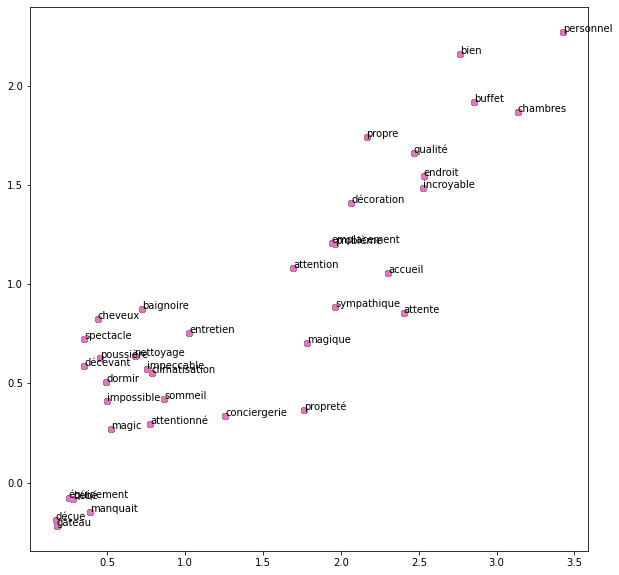

In [222]:
#graphique dans le plan

plt.figure(figsize=(10, 10))
for i in range(dfMots.shape[0]):
    plt.scatter(dfMots.V1,dfMots.V2,s=30)
    plt.annotate(dfMots.index[i],(dfMots.V1[i],dfMots.V2[i]))
plt.show()

**Interprétation du graphique : 6 zones.** 
Positif en haut à droite : personnel/chambres/buffet = bien.
Positif en dessous : endroit incroyable, propre, qualité.
Au centre : emplacement=problème (termes superposés).
Au centre aussi : Accueil=attente mais aussi attention et sympatique.
A gauche : on retrouve des pb afférents à des incidents de nettoyage : cheveux dans la baignoire, présence de poussière. Egalement, une impossibilité selon certains clients de bien dormir. Non liée à la climatisation (associée à impeccable).
ET on retrouve le couple spectacle / décevant, et le couple décevant /poussière.
Enfin, en bas à gauche, nous retrouvons les équipements manquants pour bébé et sur la déception isolée quant au gâteau. 

# IV. Appel à un modèle pré-entraîné d'apprentissage des termes

Partage du code pour creuser au besoin les évocations associées des termes pour de futurs plans d'action. 

In [46]:
#GitHub recommandé par R.Rakotomalala. https://fauconnier. github.io/
#Dictionnaire généraliste avec représentation spatiale des termes
from gensim.models import keyedvectors
trained = keyedvectors.load_word2vec_format("frWac_no_postag_no_phrase_500_skip_cut100.bin", binary=True, unicode_errors='ignore')
print(len(trained.key_to_index))

119227


1 - Points forts du personnel à capitaliser (termes associés)

In [98]:
#selon ce modèle, quels sont les termes les plus similaires à "personnel"et qui sont clés (= retrait de "manque")?
trained.most_similar(positive=['personnel'],negative=['manque'],topn=5)

[('nominatif', 0.32981908321380615),
 ('établissement', 0.32695937156677246),
 ('personnels', 0.32490742206573486),
 ('confidentialité', 0.2940655052661896),
 ('conformément', 0.29240378737449646)]

2-Points forts d'un spectacle (termes associés)

In [101]:
trained.most_similar(positive=['spectacle'],negative=['décevant'],topn=5)

[('théâtre', 0.4304552674293518),
 ('spectacles', 0.42559048533439636),
 ('artiste', 0.38758954405784607),
 ('circassien', 0.3834640383720398),
 ('danse', 0.36808231472969055)]

# IV. Conclusion

Ce premier notebook de découverte et de test & learn de l'univers des hôtels Disney confirmerait : 
- la faisabilité de conduire les analyses sur un notebook traduit (français, langue majoritaire ; pas de différences significatives dans le présent cas - à confirmer avec les autres hôtels et parcs. Irritants liés à un incident du customer-journey,...)
- la pertinence et la bonne maniabilité du package Word2Vec pour identifier les irritants parmi les commentaires ; voire dans le titre (synthèse du commentaire)